In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline 
import time
import numpy as np
%matplotlib inline
import matplotlib
import pandas as pd
import os

from random import randint

In [2]:
nPoints = 18
protoFile = "models/pose_deploy_linevec.prototxt"
weightsFile = "models/pose_iter_440000.caffemodel"
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16] ]

# index of pafs correspoding to the POSE_PAIRS
# e.g for POSE_PAIR(1,2), the PAFs are located at indices (31,32) of output, Similarly, (1,5) -> (39,40) and so on.
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], 
          [19,20], [21,22], [23,24], [25,26], [27,28], [29,30], 
          [47,48], [49,50], [53,54], [51,52], [55,56], 
          [37,38], [45,46]]

colors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0]]

columns = ['label', 'coordinate 0', 'coordinate 1', 'coordinate 2', 'coordinate 3', 'coordinate 4', 'coordinate 5', 'coordinate 6', 'coordinate 7',
          'coordinate 8', 'coordinate 9', 'coordinate 10', 'coordinate 11', 'coordinate 12', 'coordinate 13', 'coordinate 14', 'coordinate 15', 'coordinate 16',
          'coordinate 17', 'coordinate 18', 'coordinate 19', 'coordinate 20', 'coordinate 21', 'coordinate 22', 'coordinate 23', 'coordinate 24', 'coordinate 25',
          'coordinate 26', 'coordinate 27', 'coordinate 28', 'coordinate 29', 'coordinate 30', 'coordinate 31', 'coordinate 32', 'coordinate 33', 'coordinate 34',
          'coordinate 35']

In [3]:
# Find the Keypoints using Non Maximum Suppression on the Confidence Map
def getKeypoints(probMap, threshold=0.1):
    
    mapSmooth = cv.GaussianBlur(probMap,(3,3),0,0)

    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []
    
    #find the blobs
    contours, _ = cv.findContours(mapMask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    #for each blob find the maxima
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv.minMaxLoc(maskedProbMap)
        keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

    return keypoints

In [4]:
def getValidPairs(output, frameWidth, frameHeight, detected_keypoints):
    valid_pairs = []
    invalid_pairs = []
    n_interp_samples = 10
    paf_score_th = 0.1
    conf_th = 0.7
    # loop for every POSE_PAIR
    for k in range(len(mapIdx)):
        # A->B constitute a limb
        pafA = output[0, mapIdx[k][0], :, :]
        pafB = output[0, mapIdx[k][1], :, :]
        pafA = cv.resize(pafA, (frameWidth, frameHeight))
        pafB = cv.resize(pafB, (frameWidth, frameHeight))

        # Find the keypoints for the first and second limb
        candA = detected_keypoints[POSE_PAIRS[k][0]]
        candB = detected_keypoints[POSE_PAIRS[k][1]]
        nA = len(candA)
        nB = len(candB)

        # If keypoints for the joint-pair is detected
        # check every joint in candA with every joint in candB 
        # Calculate the distance vector between the two joints
        # Find the PAF values at a set of interpolated points between the joints
        # Use the above formula to compute a score to mark the connection valid
        
        if( nA != 0 and nB != 0):
            valid_pair = np.zeros((0,3))
            for i in range(nA):
                max_j=-1
                maxScore = -1
                found = 0
                for j in range(nB):
                    # Find d_ij
                    d_ij = np.subtract(candB[j][:2], candA[i][:2])
                    norm = np.linalg.norm(d_ij)
                    if norm:
                        d_ij = d_ij / norm
                    else:
                        continue
                    # Find p(u)
                    interp_coord = list(zip(np.linspace(candA[i][0], candB[j][0], num=n_interp_samples),
                                            np.linspace(candA[i][1], candB[j][1], num=n_interp_samples)))
                    # Find L(p(u))
                    paf_interp = []
                    for k in range(len(interp_coord)):
                        paf_interp.append([pafA[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))],
                                           pafB[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))] ]) 
                    # Find E
                    paf_scores = np.dot(paf_interp, d_ij)
                    avg_paf_score = sum(paf_scores)/len(paf_scores)
                    
                    # Check if the connection is valid
                    # If the fraction of interpolated vectors aligned with PAF is higher then threshold -> Valid Pair  
                    if ( len(np.where(paf_scores > paf_score_th)[0]) / n_interp_samples ) > conf_th :
                        if avg_paf_score > maxScore:
                            max_j = j
                            maxScore = avg_paf_score
                            found = 1
                # Append the connection to the list
                if found:            
                    valid_pair = np.append(valid_pair, [[candA[i][3], candB[max_j][3], maxScore]], axis=0)

            # Append the detected connections to the global list
            valid_pairs.append(valid_pair)
        else: # If no keypoints are detected
            # print("No Connection : k = {}".format(k))
            invalid_pairs.append(k)
            valid_pairs.append([])
    #print(valid_pairs)
    return valid_pairs, invalid_pairs

In [5]:
# This function creates a list of keypoints belonging to each person
# For each detected valid pair, it assigns the joint(s) to a person
# It finds the person and index at which the joint should be added. This can be done since we have an id for each joint
def getPersonwiseKeypoints(valid_pairs, invalid_pairs, keypoints_list):
    # the last number in each row is the overall score 
    personwiseKeypoints = -1 * np.ones((0, 19))

    for k in range(len(mapIdx)):
        if k not in invalid_pairs:
            partAs = valid_pairs[k][:,0]
            partBs = valid_pairs[k][:,1]
            indexA, indexB = np.array(POSE_PAIRS[k])

            for i in range(len(valid_pairs[k])): 
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):
                    if personwiseKeypoints[j][indexA] == partAs[i]:
                        person_idx = j
                        found = 1
                        break

                if found:
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int), 2] + valid_pairs[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(19)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    # add the keypoint_scores for the two keypoints and the paf_score 
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int), 2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints, row])
    return personwiseKeypoints

In [6]:
def detect(img_path, net):
    image1 = cv.imread(img_path)
    image1 = cv.resize(image1, (240, 240))
    frameWidth = image1.shape[1]
    frameHeight = image1.shape[0]
    # net = cv.dnn.readNetFromCaffe(protoFile, weightsFile)
    # net.setPreferableBackend(cv.dnn.DNN_TARGET_CPU)
    
    inHeight = frameHeight
    inWidth = frameWidth
    
    inpBlob = cv.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                              (0, 0, 0), swapRB=False, crop=False)
    
    net.setInput(inpBlob)
    output = net.forward()
    i = 0
    probMap = output[0, i, :, :]
    probMap = cv.resize(probMap, (frameWidth, frameHeight))
    detected_keypoints = []
    keypoints_list = np.zeros((0,3))
    keypoint_id = 0
    threshold = 0.05
    
    for part in range(nPoints):
        probMap = output[0,part,:,:]
        probMap = cv.resize(probMap, (image1.shape[1], image1.shape[0]))
        keypoints = getKeypoints(probMap, threshold)
        keypoints_with_id = []
        for i in range(len(keypoints)):
            keypoints_with_id.append(keypoints[i] + (keypoint_id,))
            keypoints_list = np.vstack([keypoints_list, keypoints[i]])
            keypoint_id += 1
    
        detected_keypoints.append(keypoints_with_id)
    frameClone = image1.copy()
    valid_pairs, invalid_pairs = getValidPairs(output, frameWidth, frameHeight, detected_keypoints)
    personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs, keypoints_list)
    return keypoints_list, personwiseKeypoints, frameClone
    

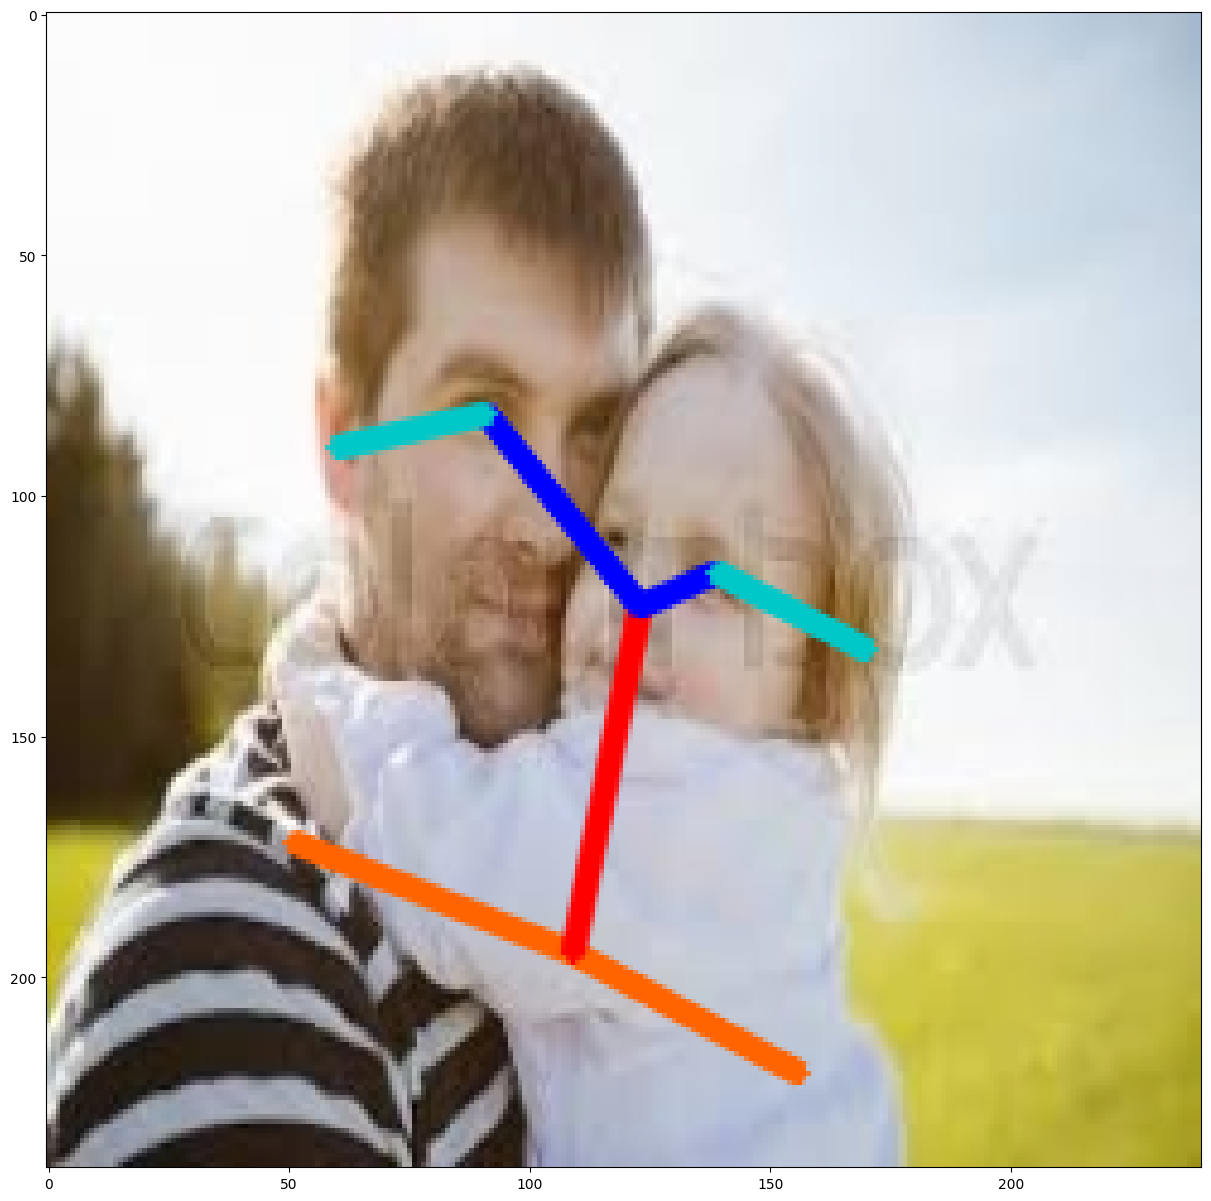

In [11]:
net = cv.dnn.readNetFromCaffe(protoFile, weightsFile)
net.setPreferableBackend(cv.dnn.DNN_TARGET_CPU)
k_list, persKpoints, frameClone = detect("data/HAR/HumanActionRecognition/train/Image_3.jpg", net)
# print(np.int32(k_list))
# labels_df = pd.read_csv("data/HAR/HumanActionRecognition/Training_set.csv");
# label = labels_df[labels_df['filename'] == 'Image_1.jpg']['label'].values[0]
# print(label)
# print(persKpoints)
# index_of_min_list = min(range(len(persKpoints)), key=lambda i: list(persKpoints[i]).count(-1))
# print(index_of_min_list)
for i in range(17):
    for n in range(len(persKpoints)):
        index = persKpoints[n][np.array(POSE_PAIRS[i])]
        if -1 in index:
            continue
        B = np.int32(k_list[index.astype(int), 0])
        A = np.int32(k_list[index.astype(int), 1])
        cv.line(frameClone, (B[0], A[0]), (B[1], A[1]), colors[i], 3, cv.LINE_AA)
# for i in range(18):
#     index = persKpoints[index_of_min_list][i]
#     if -1 == index:
#         continue
#     print(index)
#     print(np.int32(k_list[index.astype(int)]))
#     x = np.int32(k_list[index.astype(int)])
    # B = np.int32(k_list[index.astype(int), 0])
    # A = np.int32(k_list[index.astype(int), 1])
    # print((B[0], A[0]), i)
    # print((B[1], A[1]), i)
    # cv.line(frameClone, (B[0], A[0]), (B[1], A[1]), colors[i], 3, cv.LINE_AA)
    # cv.circle(frameClone, (x[0], x[1]), 3, [0,0,255], -1, cv.LINE_AA)
    # cv.circle(frameClone, (B[1], A[1]), 3, [0,255,0], -1, cv.LINE_AA)
        
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])

In [9]:
def preprocess_dataset(path):
    c = 0
    labels_df = pd.read_csv("data/HAR/HumanActionRecognition/Training_set.csv");
    net = cv.dnn.readNetFromCaffe(protoFile, weightsFile)
    net.setPreferableBackend(cv.dnn.DNN_TARGET_CPU)
    output_df = pd.DataFrame(columns=columns)
    for filename in os.listdir(path):
        row = []
        file_path = os.path.join(path, filename)
        label = labels_df[labels_df['filename'] == filename]['label'].values[0]
        row.append(label)
        key_list, personKeyPoints, _ = detect(file_path, net)
        if len(personKeyPoints) == 0:
            continue
        index_of_min_list = min(range(len(personKeyPoints)), key=lambda i: list(personKeyPoints[i]).count(-1))
        for i in range(18):
            index = personKeyPoints[index_of_min_list][i]
            if -1 == index:
                row = row + [0, 0]
                continue
            point = np.int32(key_list[index.astype(int)])
            # row.append((point[0], point[1]))
            row += [point[0], point[1]]
        print(row)
        output_df.loc[len(output_df)] = row
        c += 1
        if c == 3:
            break
    print(output_df)
                

In [10]:
preprocess_dataset("data/HAR/HumanActionRecognition/train")

['sitting', 91, 59, 107, 100, 76, 98, 59, 164, 52, 172, 138, 108, 132, 219, 83, 228, 77, 220, 12, 211, 0, 0, 122, 229, 0, 0, 0, 0, 83, 44, 99, 44, 0, 0, 123, 44]
['fighting', 115, 106, 115, 115, 100, 115, 91, 124, 91, 123, 123, 115, 139, 124, 155, 130, 107, 148, 107, 179, 100, 204, 116, 148, 115, 179, 107, 204, 114, 100, 116, 100, 108, 100, 116, 100]
['laughing', 140, 92, 67, 194, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 124, 68, 141, 67, 76, 83, 171, 53]
      label  coordinate 0  coordinate 1  coordinate 2  coordinate 3  \
0   sitting            91            59           107           100   
1  fighting           115           106           115           115   
2  laughing           140            92            67           194   

   coordinate 4  coordinate 5  coordinate 6  coordinate 7  coordinate 8  ...  \
0            76            98            59           164            52  ...   
1           100           115            91           124       